In [2]:
import numpy as np
import os
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.vgg19 import VGG19, preprocess_input
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler, Callback
from tensorflow.keras import optimizers
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Flatten
import matplotlib.pyplot as plt
import tensorflow as tf

In [3]:
def load_training():
    images = np.load(os.path.join('../../Data_final_fullver', 'X_train.npy'))
    labels = np.load(os.path.join('../../Data_final_fullver', 'train_labels3_num.npy'))
    filenames = np.load(os.path.join('../../Data_final_fullver', 'CBIS_train_FNs.npy'))
    return images, labels, filenames


def load_testing():
    images = np.load(os.path.join('../../Data_final_fullver', 'X_test.npy'))
    labels = np.load(os.path.join('../../Data_final_fullver', 'test_labels3_num.npy'))
    filenames = np.load(os.path.join('../../Data_final_fullver', 'CBIS_test_FNs.npy'))
    return images, labels, filenames

In [4]:
train_images, train_labels, Fn= load_training()
test_images, test_labels, Fn= load_testing()

n_train_img = train_images.shape[0]
n_test_img = test_images.shape[0]
print("Train size: %d \t Test size: %d" % (n_train_img, n_test_img))

img_w = train_images.shape[1]
img_h = train_images.shape[2]
print("Image size: %dx%d" % (img_w, img_h))

Train size: 2642 	 Test size: 578
Image size: 256x256


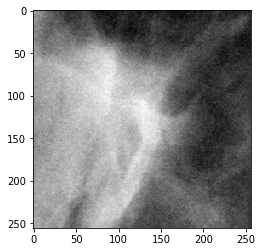

Label: 2
FN: Calc-Training_P_00479_LEFT_MLO.png


In [7]:
idx = 10

plt.imshow(test_images[idx][:,:,0], cmap='gray')
plt.show()

print("Label: " + str(test_labels[idx]))
print("FN: " + str(Fn[idx]))

In [8]:
train_labels = to_categorical(train_labels)
test_labels_raw = test_labels.copy()
test_labels = to_categorical(test_labels)

In [9]:
train_images.shape

(2642, 256, 256, 1)

In [10]:
train_images = train_images.reshape((n_train_img, img_w, img_h, 1))
test_images = test_images.reshape((n_test_img, img_w, img_h, 1))

In [11]:
train_images = train_images.astype('uint16')/256
test_images = test_images.astype('uint16')/256

train_images = np.repeat(train_images, 3, axis=3)
test_images = np.repeat(test_images, 3, axis=3)

In [12]:
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    validation_split=0.2,
    rotation_range=180,
    shear_range=15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='reflect'
)

In [13]:
train_datagen.fit(train_images)

train_generator = train_datagen.flow(train_images, train_labels, batch_size=128, subset='training')
validation_generator = train_datagen.flow(train_images, train_labels, batch_size=128, subset='validation')

preprocess_input(test_images);

In [14]:
def create_vgg19(verbose=False, fc_size=256, output = 4, dropout=None):

    vgg19_base = VGG19(weights='imagenet',
                       include_top=False,
                       input_shape=(256, 256, 3))
    vgg19 = models.Sequential()
    vgg19.add(vgg19_base)

    vgg19.add(layers.Flatten())
    if dropout is not None:
        vgg19.add(layers.Dropout(dropout))
    vgg19.add(layers.Dense(1024, activation='relu'))
    vgg19.add(layers.Dense(fc_size, activation='relu'))
    vgg19.add(layers.Dense(output, activation='softmax'))

    vgg19_base.trainable = False
    
    if verbose:
        vgg19_base.summary()
        vgg19.summary()

    return vgg19

In [12]:
vgg = VGG19(weights='imagenet',
                       include_top=False,
                       input_shape=(256, 256, 3))
for layer in vgg.layers:
    layer.trainable = False
vgg_maxpool = vgg.get_layer('block5_pool').output
FeatureFlatten = Flatten()(vgg_maxpool)
dense1 = Dense(1024, name = 'dense1', activation = 'relu')(FeatureFlatten)
dense2 = Dense(128, name = 'dense2', activation = 'relu')(dense1)
predictions = Dense(4, name = 'predictions', activation = 'softmax')(dense2)

new_vgg = Model(inputs = vgg.input, outputs = predictions)
new_vgg.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 256, 256, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 256, 256, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 128, 128, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 128, 128, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 128, 128, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 64, 64, 128)       0     

In [13]:
vgg19_calc_or_mass_best_Adam = new_vgg

In [14]:
vgg19_calc_or_mass_best_RMSprop = new_vgg

### Adam

In [15]:
earlystopping = EarlyStopping(monitor='val_loss', mode='min', patience=30, verbose=1)

checkpoint = ModelCheckpoint('../../model/vgg19_calc_or_mass_best_Adam.h5', 
        monitor='val_loss', mode='min', verbose=1, 
        save_best_only=True, save_freq='epoch'
)

vgg19_calc_or_mass_best_Adam.compile(optimizer=optimizers.Adam(learning_rate=0.0001),
                                            loss='categorical_crossentropy',
                                            metrics=[tf.keras.metrics.Recall(name='recall')])

In [16]:
# Train
history_vgg19_calc_or_mass_best_Adam = vgg19_calc_or_mass_best_Adam.fit_generator(
        train_generator,
        steps_per_epoch=n_train_img // 256,
        epochs=300,
        validation_data=validation_generator,
        callbacks=[checkpoint, earlystopping],
        shuffle=True,
        verbose=1,
        initial_epoch=0
)

Instructions for updating:
Please use Model.fit, which supports generators.
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 11 steps, validate for 5 steps
Epoch 1/300
10/11 [==========================>...] - ETA: 1s - loss: 2.0207 - recall: 0.2727
Epoch 00001: val_loss improved from inf to 1.39628, saving model to ../../model/vgg19_calc_or_mass_best_Adam.h5
11/11 [==============================] - 26s 2s/step - loss: 1.9642 - recall: 0.2749 - val_loss: 1.3963 - val_recall: 0.3162
Epoch 2/300
10/11 [==========================>...] - ETA: 1s - loss: 1.3283 - recall: 0.2870
Epoch 00002: val_loss improved from 1.39628 to 1.22993, saving model to ../../model/vgg19_calc_or_mass_best_Adam.h5
11/11 [==============================] - 22s 2s/step - loss: 1.3209 - recall: 0.2857 - val_loss: 1.2299 - val_recall: 0.3094
Epoch 3/300
10/11 [==========================>...] - ETA: 1s - loss: 1.1698 - recall: 0.3603
Epoch 00003: val_loss improved from 1.22993 to 1.20768, saving model to ../.

Epoch 57/300
10/11 [==========================>...] - ETA: 1s - loss: 0.8273 - recall: 0.5320
Epoch 00057: val_loss did not improve from 0.89823
11/11 [==============================] - 22s 2s/step - loss: 0.8234 - recall: 0.5403 - val_loss: 0.9587 - val_recall: 0.4718
Epoch 58/300
10/11 [==========================>...] - ETA: 1s - loss: 0.7745 - recall: 0.5623
Epoch 00058: val_loss did not improve from 0.89823
11/11 [==============================] - 21s 2s/step - loss: 0.7817 - recall: 0.5600 - val_loss: 0.9128 - val_recall: 0.4957
Epoch 59/300
10/11 [==========================>...] - ETA: 1s - loss: 0.7785 - recall: 0.5556
Epoch 00059: val_loss did not improve from 0.89823
11/11 [==============================] - 22s 2s/step - loss: 0.7771 - recall: 0.5608 - val_loss: 0.9850 - val_recall: 0.4872
Epoch 60/300
10/11 [==========================>...] - ETA: 1s - loss: 0.7543 - recall: 0.5825
Epoch 00060: val_loss did not improve from 0.89823
11/11 [==============================] - 22s 

In [17]:
models.save_model(vgg19_calc_or_mass_best_Adam, '../model/vgg19_calc_or_mass_end_Adam.h5')

In [18]:
tra_loss_fe = history_vgg19_calc_or_mass_best_Adam.history['loss']
tra_acc_fe = history_vgg19_calc_or_mass_best_Adam.history['recall']
val_loss_fe = history_vgg19_calc_or_mass_best_Adam.history['val_loss']
val_acc_fe = history_vgg19_calc_or_mass_best_Adam.history['val_recall']

In [20]:
epochs_fe = range(1, len(tra_acc_fe)+1)
end_epoch_fe = len(tra_acc_fe)

opt_epoch_fe = val_loss_fe.index(min(val_loss_fe)) + 1

end_val_loss_fe = val_loss_fe[-1]
end_val_acc_fe = val_acc_fe[-1]
opt_val_loss_fe = val_loss_fe[opt_epoch_fe-1]
opt_val_acc_fe = val_acc_fe[opt_epoch_fe-1]

opt_vgg19_calc_or_mass = models.load_model('../../model/vgg19_calc_or_mass_best_Adam.h5')
test_loss_fe, test_acc_fe = vgg19_calc_or_mass_best_Adam.evaluate(test_images, test_labels, verbose=False)
opt_test_loss_fe, opt_test_acc_fe = opt_vgg19_calc_or_mass.evaluate(test_images, test_labels, verbose=False)

In [21]:
print("VGG19 calc or mass\n")

print("Epoch [end]: %d" % end_epoch_fe)
print("Epoch [opt]: %d" % opt_epoch_fe)
print("Valid recall [end]: %.4f" % end_val_acc_fe)
print("Valid recall [opt]: %.4f" % opt_val_acc_fe)
print("Test recall [end]:  %.4f" % test_acc_fe)
print("Test recall [opt]:  %.4f" % opt_test_acc_fe)
print("Valid loss [end]: %.4f" % end_val_loss_fe)
print("Valid loss [opt]: %.4f" % opt_val_loss_fe)
print("Test loss [end]:  %.4f" % test_loss_fe)
print("Test loss [opt]:  %.4f" % opt_test_loss_fe)

VGG19 calc or mass

Epoch [end]: 72
Epoch [opt]: 42
Valid recall [end]: 0.5436
Valid recall [opt]: 0.5026
Test recall [end]:  0.5428
Test recall [opt]:  0.5350
Valid loss [end]: 0.9174
Valid loss [opt]: 0.8982
Test loss [end]:  0.9810
Test loss [opt]:  1.0364


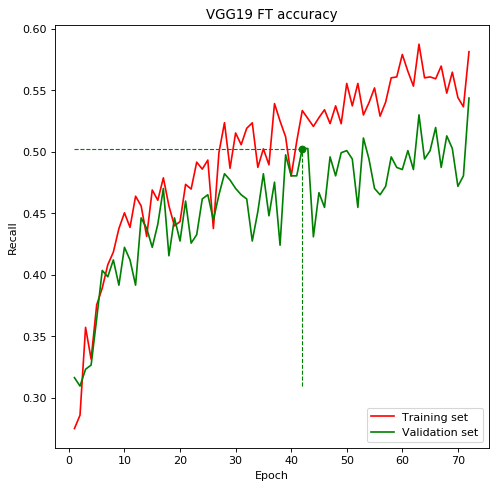

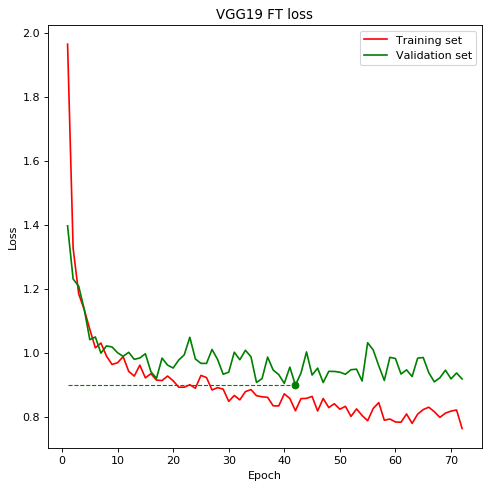

In [22]:
# Model accuracy
plt.figure(figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.title('VGG19 FT accuracy')
plt.ylabel('Recall')
plt.xlabel('Epoch')
plt.plot(epochs_fe, tra_acc_fe, 'r', label='Training set')
plt.plot(epochs_fe, val_acc_fe, 'g', label='Validation set')
plt.plot(opt_epoch_fe, val_acc_fe[opt_epoch_fe-1], 'go')
plt.vlines(opt_epoch_fe, min(val_acc_fe), opt_val_acc_fe, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_acc_fe, 1, opt_epoch_fe, linestyle="dashed", color='g', linewidth=1)
plt.legend(loc='lower right')

# Model loss
plt.figure(figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.title('VGG19 FT loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.plot(epochs_fe, tra_loss_fe, 'r', label='Training set')
plt.plot(epochs_fe, val_loss_fe, 'g', label='Validation set')
plt.plot(opt_epoch_fe, val_loss_fe[opt_epoch_fe-1], 'go')
plt.vlines(opt_epoch_fe, min(val_loss_fe), opt_val_loss_fe, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_loss_fe, 1, opt_epoch_fe, linestyle="dashed", color='g', linewidth=1)
plt.legend();

### SGD

In [25]:
vgg19_calc_or_mass_best_SGD = create_vgg19(dropout=0.5, fc_size=128, output = 4)

earlystopping = EarlyStopping(monitor='val_loss', mode='min', patience=30, verbose=1)

checkpoint = ModelCheckpoint('../model/vgg19_calc_or_mass_best_SGD.h5', 
        monitor='val_loss', mode='min', verbose=1, 
        save_best_only=True, save_freq='epoch'
)

vgg19_calc_or_mass_best_SGD.compile(optimizer=optimizers.SGD(learning_rate=0.0001),
                                            loss='categorical_crossentropy',
                                            metrics=[tf.keras.metrics.Recall(name='recall')])

In [26]:
# Train
history_vgg19_calc_or_mass_best_SGD = vgg19_calc_or_mass_best_SGD.fit_generator(
        train_generator,
        steps_per_epoch=n_train_img // 256,
        epochs=300,
        validation_data=validation_generator,
        callbacks=[checkpoint, earlystopping],
        shuffle=True,
        verbose=1,
        initial_epoch=0
)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 11 steps, validate for 5 steps
Epoch 1/300
10/11 [==========================>...] - ETA: 1s - loss: 3.0380 - recall: 0.1805
Epoch 00001: val_loss improved from inf to 1.80669, saving model to ../model/vgg19_calc_or_mass_best_SGD.h5
11/11 [==============================] - 23s 2s/step - loss: 3.0038 - recall: 0.1839 - val_loss: 1.8067 - val_recall: 0.1675
Epoch 2/300
10/11 [==========================>...] - ETA: 1s - loss: 2.5128 - recall: 0.2062
Epoch 00002: val_loss did not improve from 1.80669
11/11 [==============================] - 22s 2s/step - loss: 2.4935 - recall: 0.2036 - val_loss: 1.8378 - val_recall: 0.2188
Epoch 3/300
10/11 [==========================>...] - ETA: 1s - loss: 2.4284 - recall: 0.2172
Epoch 00003: val_loss improved from 1.80669 to 1.74747, saving model to ../model/vgg19_calc_or_mass_best_SGD.h5
11/11 [==============================] - 22s 2s/step - loss: 2.4007 - recall: 0.2150 - val_loss: 1.7475 - val

Epoch 28/300
10/11 [==========================>...] - ETA: 1s - loss: 1.7359 - recall: 0.2753
Epoch 00028: val_loss improved from 1.36897 to 1.35302, saving model to ../model/vgg19_calc_or_mass_best_SGD.h5
11/11 [==============================] - 22s 2s/step - loss: 1.7218 - recall: 0.2827 - val_loss: 1.3530 - val_recall: 0.2821
Epoch 29/300
10/11 [==========================>...] - ETA: 1s - loss: 1.6457 - recall: 0.2912
Epoch 00029: val_loss did not improve from 1.35302
11/11 [==============================] - 21s 2s/step - loss: 1.6583 - recall: 0.2903 - val_loss: 1.4527 - val_recall: 0.2615
Epoch 30/300
10/11 [==========================>...] - ETA: 1s - loss: 1.6935 - recall: 0.2744
Epoch 00030: val_loss improved from 1.35302 to 1.34171, saving model to ../model/vgg19_calc_or_mass_best_SGD.h5
11/11 [==============================] - 22s 2s/step - loss: 1.6979 - recall: 0.2766 - val_loss: 1.3417 - val_recall: 0.2444
Epoch 31/300
10/11 [==========================>...] - ETA: 1s - loss

10/11 [==========================>...] - ETA: 1s - loss: 1.3973 - recall: 0.2694
Epoch 00087: val_loss did not improve from 1.19593
11/11 [==============================] - 21s 2s/step - loss: 1.4071 - recall: 0.2660 - val_loss: 1.2168 - val_recall: 0.2222
Epoch 88/300
10/11 [==========================>...] - ETA: 1s - loss: 1.3470 - recall: 0.2797
Epoch 00088: val_loss did not improve from 1.19593
11/11 [==============================] - 23s 2s/step - loss: 1.3720 - recall: 0.2720 - val_loss: 1.2143 - val_recall: 0.2154
Epoch 89/300
10/11 [==========================>...] - ETA: 1s - loss: 1.4077 - recall: 0.2547
Epoch 00089: val_loss improved from 1.19593 to 1.19052, saving model to ../model/vgg19_calc_or_mass_best_SGD.h5
11/11 [==============================] - 22s 2s/step - loss: 1.4082 - recall: 0.2585 - val_loss: 1.1905 - val_recall: 0.2017
Epoch 90/300
10/11 [==========================>...] - ETA: 1s - loss: 1.3961 - recall: 0.2593
Epoch 00090: val_loss did not improve from 1.190

Epoch 117/300
10/11 [==========================>...] - ETA: 1s - loss: 1.2910 - recall: 0.2930
Epoch 00117: val_loss did not improve from 1.15694
11/11 [==============================] - 21s 2s/step - loss: 1.2980 - recall: 0.2903 - val_loss: 1.1799 - val_recall: 0.2120
Epoch 118/300
10/11 [==========================>...] - ETA: 1s - loss: 1.3544 - recall: 0.2492
Epoch 00118: val_loss improved from 1.15694 to 1.15627, saving model to ../model/vgg19_calc_or_mass_best_SGD.h5
11/11 [==============================] - 22s 2s/step - loss: 1.3437 - recall: 0.2530 - val_loss: 1.1563 - val_recall: 0.2103
Epoch 119/300
10/11 [==========================>...] - ETA: 1s - loss: 1.3545 - recall: 0.2688
Epoch 00119: val_loss did not improve from 1.15627
11/11 [==============================] - 22s 2s/step - loss: 1.3512 - recall: 0.2685 - val_loss: 1.1955 - val_recall: 0.2068
Epoch 120/300
10/11 [==========================>...] - ETA: 1s - loss: 1.2929 - recall: 0.2736
Epoch 00120: val_loss did not i

Epoch 147/300
10/11 [==========================>...] - ETA: 1s - loss: 1.2476 - recall: 0.2820
Epoch 00147: val_loss did not improve from 1.13554
11/11 [==============================] - 21s 2s/step - loss: 1.2525 - recall: 0.2789 - val_loss: 1.2102 - val_recall: 0.1675
Epoch 148/300
10/11 [==========================>...] - ETA: 1s - loss: 1.3392 - recall: 0.2508
Epoch 00148: val_loss did not improve from 1.13554
11/11 [==============================] - 22s 2s/step - loss: 1.3295 - recall: 0.2585 - val_loss: 1.1638 - val_recall: 0.2120
Epoch 149/300
10/11 [==========================>...] - ETA: 1s - loss: 1.2620 - recall: 0.2930
Epoch 00149: val_loss did not improve from 1.13554
11/11 [==============================] - 22s 2s/step - loss: 1.2706 - recall: 0.2912 - val_loss: 1.1566 - val_recall: 0.2154
Epoch 150/300
10/11 [==========================>...] - ETA: 1s - loss: 1.3103 - recall: 0.2703
Epoch 00150: val_loss did not improve from 1.13554
11/11 [==============================] - 

In [27]:
models.save_model(vgg19_calc_or_mass_best_SGD, '../model/vgg19_calc_or_mass_end_SGD.h5')

In [28]:
tra_loss_fe = history_vgg19_calc_or_mass_best_SGD.history['loss']
tra_acc_fe = history_vgg19_calc_or_mass_best_SGD.history['recall']
val_loss_fe = history_vgg19_calc_or_mass_best_SGD.history['val_loss']
val_acc_fe = history_vgg19_calc_or_mass_best_SGD.history['val_recall']

epochs_fe = range(1, len(tra_acc_fe)+1)
end_epoch_fe = len(tra_acc_fe)

opt_epoch_fe = val_loss_fe.index(min(val_loss_fe)) + 1

end_val_loss_fe = val_loss_fe[-1]
end_val_acc_fe = val_acc_fe[-1]
opt_val_loss_fe = val_loss_fe[opt_epoch_fe-1]
opt_val_acc_fe = val_acc_fe[opt_epoch_fe-1]

opt_vgg19_calc_or_mass = models.load_model('../model/vgg19_calc_or_mass_best_SGD.h5')
test_loss_fe, test_acc_fe = vgg19_calc_or_mass_best_SGD.evaluate(test_images, test_labels, verbose=False)
opt_test_loss_fe, opt_test_acc_fe = opt_vgg19_calc_or_mass.evaluate(test_images, test_labels, verbose=False)

print("VGG19 calc or mass\n")

print("Epoch [end]: %d" % end_epoch_fe)
print("Epoch [opt]: %d" % opt_epoch_fe)
print("Valid recall [end]: %.4f" % end_val_acc_fe)
print("Valid recall [opt]: %.4f" % opt_val_acc_fe)
print("Test recall [end]:  %.4f" % test_acc_fe)
print("Test recall [opt]:  %.4f" % opt_test_acc_fe)
print("Valid loss [end]: %.4f" % end_val_loss_fe)
print("Valid loss [opt]: %.4f" % opt_val_loss_fe)
print("Test loss [end]:  %.4f" % test_loss_fe)
print("Test loss [opt]:  %.4f" % opt_test_loss_fe)

VGG19 calc or mass

Epoch [end]: 158
Epoch [opt]: 128
Valid recall [end]: 0.2120
Valid recall [opt]: 0.2034
Test recall [end]:  0.3219
Test recall [opt]:  0.3079
Valid loss [end]: 1.1749
Valid loss [opt]: 1.1355
Test loss [end]:  1.1564
Test loss [opt]:  1.1836


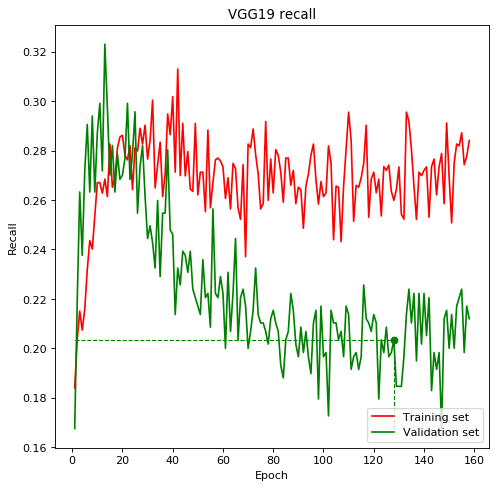

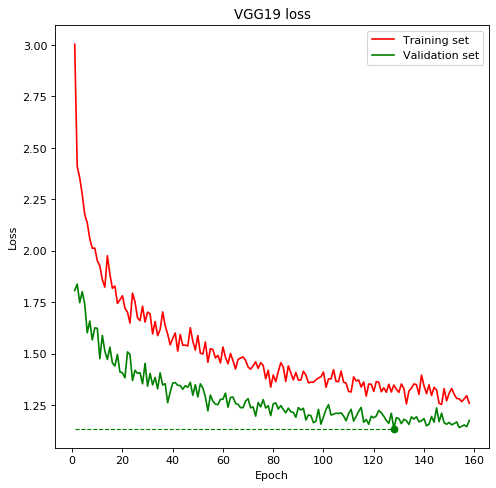

In [29]:
# Model accuracy
plt.figure(figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.title('VGG19 recall')
plt.ylabel('Recall')
plt.xlabel('Epoch')
plt.plot(epochs_fe, tra_acc_fe, 'r', label='Training set')
plt.plot(epochs_fe, val_acc_fe, 'g', label='Validation set')
plt.plot(opt_epoch_fe, val_acc_fe[opt_epoch_fe-1], 'go')
plt.vlines(opt_epoch_fe, min(val_acc_fe), opt_val_acc_fe, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_acc_fe, 1, opt_epoch_fe, linestyle="dashed", color='g', linewidth=1)
plt.legend(loc='lower right')

# Model loss
plt.figure(figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.title('VGG19 loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.plot(epochs_fe, tra_loss_fe, 'r', label='Training set')
plt.plot(epochs_fe, val_loss_fe, 'g', label='Validation set')
plt.plot(opt_epoch_fe, val_loss_fe[opt_epoch_fe-1], 'go')
plt.vlines(opt_epoch_fe, min(val_loss_fe), opt_val_loss_fe, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_loss_fe, 1, opt_epoch_fe, linestyle="dashed", color='g', linewidth=1)
plt.legend();

### RMSprop

In [30]:
earlystopping = EarlyStopping(monitor='val_loss', mode='min', patience=30, verbose=1)

checkpoint = ModelCheckpoint('../model/vgg19_calc_or_mass_best_RMSprop.h5', 
        monitor='val_loss', mode='min', verbose=1, 
        save_best_only=True, save_freq='epoch'
)

vgg19_calc_or_mass_best_RMSprop.compile(optimizer=optimizers.RMSprop(learning_rate=0.0001),
                                            loss='categorical_crossentropy',
                                            metrics=[tf.keras.metrics.Recall(name='recall')])

In [31]:
# Train
history_vgg19_calc_or_mass_best_RMSprop = vgg19_calc_or_mass_best_RMSprop.fit_generator(
        train_generator,
        steps_per_epoch=n_train_img // 256,
        epochs=300,
        validation_data=validation_generator,
        callbacks=[checkpoint, earlystopping],
        shuffle=True,
        verbose=1,
        initial_epoch=0
)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 11 steps, validate for 5 steps
Epoch 1/300
10/11 [==========================>...] - ETA: 1s - loss: 1.0661 - recall: 0.4680
Epoch 00001: val_loss improved from inf to 0.97493, saving model to ../model/vgg19_calc_or_mass_best_RMSprop.h5
11/11 [==============================] - 22s 2s/step - loss: 1.0502 - recall: 0.4680 - val_loss: 0.9749 - val_recall: 0.4650
Epoch 2/300
10/11 [==========================>...] - ETA: 1s - loss: 0.8786 - recall: 0.5093
Epoch 00002: val_loss did not improve from 0.97493
11/11 [==============================] - 21s 2s/step - loss: 0.8834 - recall: 0.5114 - val_loss: 1.0121 - val_recall: 0.4581
Epoch 3/300
10/11 [==========================>...] - ETA: 1s - loss: 0.8277 - recall: 0.5488
Epoch 00003: val_loss did not improve from 0.97493
11/11 [==============================] - 21s 2s/step - loss: 0.8245 - recall: 0.5494 - val_loss: 0.9762 - val_recall: 0.5026
Epoch 4/300
10/11 [======================

In [32]:
models.save_model(vgg19_calc_or_mass_best_RMSprop, '../model/vgg19_calc_or_mass_end_RMSprop.h5')

In [33]:
tra_loss_fe = history_vgg19_calc_or_mass_best_RMSprop.history['loss']
tra_acc_fe = history_vgg19_calc_or_mass_best_RMSprop.history['recall']
val_loss_fe = history_vgg19_calc_or_mass_best_RMSprop.history['val_loss']
val_acc_fe = history_vgg19_calc_or_mass_best_RMSprop.history['val_recall']

epochs_fe = range(1, len(tra_acc_fe)+1)
end_epoch_fe = len(tra_acc_fe)

opt_epoch_fe = val_loss_fe.index(min(val_loss_fe)) + 1

end_val_loss_fe = val_loss_fe[-1]
end_val_acc_fe = val_acc_fe[-1]
opt_val_loss_fe = val_loss_fe[opt_epoch_fe-1]
opt_val_acc_fe = val_acc_fe[opt_epoch_fe-1]

opt_vgg19_calc_or_mass = models.load_model('../model/vgg19_calc_or_mass_best_RMSprop.h5')
test_loss_fe, test_acc_fe = vgg19_calc_or_mass_best_RMSprop.evaluate(test_images, test_labels, verbose=False)
opt_test_loss_fe, opt_test_acc_fe = opt_vgg19_calc_or_mass.evaluate(test_images, test_labels, verbose=False)

print("VGG19 calc or mass\n")

print("Epoch [end]: %d" % end_epoch_fe)
print("Epoch [opt]: %d" % opt_epoch_fe)
print("Valid recall [end]: %.4f" % end_val_acc_fe)
print("Valid recall [opt]: %.4f" % opt_val_acc_fe)
print("Test recall [end]:  %.4f" % test_acc_fe)
print("Test recall [opt]:  %.4f" % opt_test_acc_fe)
print("Valid loss [end]: %.4f" % end_val_loss_fe)
print("Valid loss [opt]: %.4f" % opt_val_loss_fe)
print("Test loss [end]:  %.4f" % test_loss_fe)
print("Test loss [opt]:  %.4f" % opt_test_loss_fe)

VGG19 calc or mass

Epoch [end]: 35
Epoch [opt]: 5
Valid recall [end]: 0.4923
Valid recall [opt]: 0.5060
Test recall [end]:  0.5568
Test recall [opt]:  0.5568
Valid loss [end]: 0.9790
Valid loss [opt]: 0.9038
Test loss [end]:  0.9612
Test loss [opt]:  0.9566


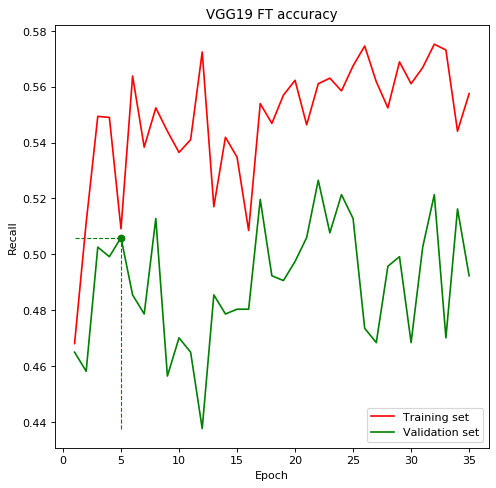

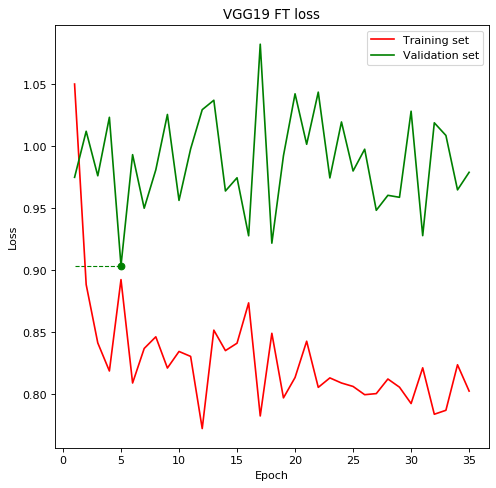

In [34]:
# Model accuracy
plt.figure(figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.title('VGG19 FT accuracy')
plt.ylabel('Recall')
plt.xlabel('Epoch')
plt.plot(epochs_fe, tra_acc_fe, 'r', label='Training set')
plt.plot(epochs_fe, val_acc_fe, 'g', label='Validation set')
plt.plot(opt_epoch_fe, val_acc_fe[opt_epoch_fe-1], 'go')
plt.vlines(opt_epoch_fe, min(val_acc_fe), opt_val_acc_fe, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_acc_fe, 1, opt_epoch_fe, linestyle="dashed", color='g', linewidth=1)
plt.legend(loc='lower right')

# Model loss
plt.figure(figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.title('VGG19 FT loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.plot(epochs_fe, tra_loss_fe, 'r', label='Training set')
plt.plot(epochs_fe, val_loss_fe, 'g', label='Validation set')
plt.plot(opt_epoch_fe, val_loss_fe[opt_epoch_fe-1], 'go')
plt.vlines(opt_epoch_fe, min(val_loss_fe), opt_val_loss_fe, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_loss_fe, 1, opt_epoch_fe, linestyle="dashed", color='g', linewidth=1)
plt.legend();

### Adadelta

In [13]:
vgg19_calc_or_mass_best_Adadelta = create_vgg19(dropout=0.5, fc_size=128, output = 4)

earlystopping = EarlyStopping(monitor='val_loss', mode='min', patience=30, verbose=1)

checkpoint = ModelCheckpoint('../model/vgg19_calc_or_mass_best_Adadelta.h5', 
        monitor='val_loss', mode='min', verbose=1, 
        save_best_only=True, save_freq='epoch'
)

vgg19_calc_or_mass_best_Adadelta.compile(optimizer=optimizers.Adadelta(learning_rate=0.0001),
                                            loss='categorical_crossentropy',
                                            metrics=[tf.keras.metrics.Recall(name='recall')])

In [14]:
# Train
history_vgg19_calc_or_mass_best_Adadelta = vgg19_calc_or_mass_best_Adadelta.fit_generator(
        train_generator,
        steps_per_epoch=n_train_img // 256,
        epochs=300,
        validation_data=validation_generator,
        callbacks=[checkpoint, earlystopping],
        shuffle=True,
        verbose=1,
        initial_epoch=0
)

Instructions for updating:
Please use Model.fit, which supports generators.
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 11 steps, validate for 5 steps
Epoch 1/300
10/11 [==========================>...] - ETA: 1s - loss: 2.6360 - recall: 0.2222
Epoch 00001: val_loss improved from inf to 1.91738, saving model to ../model/vgg19_calc_or_mass_best_Adadelta.h5
11/11 [==============================] - 26s 2s/step - loss: 2.6354 - recall: 0.2242 - val_loss: 1.9174 - val_recall: 0.2154
Epoch 2/300
10/11 [==========================>...] - ETA: 1s - loss: 2.6057 - recall: 0.2469
Epoch 00002: val_loss improved from 1.91738 to 1.89058, saving model to ../model/vgg19_calc_or_mass_best_Adadelta.h5
11/11 [==============================] - 22s 2s/step - loss: 2.5985 - recall: 0.2450 - val_loss: 1.8906 - val_recall: 0.1846
Epoch 3/300
10/11 [==========================>...] - ETA: 1s - loss: 2.6634 - recall: 0.2336
Epoch 00003: val_loss did not improve from 1.89058
11/11 [================

Epoch 28/300
10/11 [==========================>...] - ETA: 1s - loss: 2.3877 - recall: 0.2197
Epoch 00028: val_loss did not improve from 1.75336
11/11 [==============================] - 22s 2s/step - loss: 2.4158 - recall: 0.2150 - val_loss: 1.7834 - val_recall: 0.1795
Epoch 29/300
10/11 [==========================>...] - ETA: 1s - loss: 2.5214 - recall: 0.2250
Epoch 00029: val_loss did not improve from 1.75336
11/11 [==============================] - 23s 2s/step - loss: 2.5092 - recall: 0.2188 - val_loss: 1.8608 - val_recall: 0.1829
Epoch 30/300
10/11 [==========================>...] - ETA: 1s - loss: 2.3724 - recall: 0.2222
Epoch 00030: val_loss did not improve from 1.75336
11/11 [==============================] - 21s 2s/step - loss: 2.3522 - recall: 0.2226 - val_loss: 1.8230 - val_recall: 0.1778
Epoch 31/300
10/11 [==========================>...] - ETA: 1s - loss: 2.4758 - recall: 0.2141
Epoch 00031: val_loss did not improve from 1.75336
11/11 [==============================] - 23s 

Epoch 58/300
10/11 [==========================>...] - ETA: 1s - loss: 2.3424 - recall: 0.2305
Epoch 00058: val_loss did not improve from 1.67722
11/11 [==============================] - 23s 2s/step - loss: 2.3204 - recall: 0.2308 - val_loss: 1.8131 - val_recall: 0.1829
Epoch 59/300
10/11 [==========================>...] - ETA: 1s - loss: 2.3592 - recall: 0.2508
Epoch 00059: val_loss did not improve from 1.67722
11/11 [==============================] - 22s 2s/step - loss: 2.3695 - recall: 0.2493 - val_loss: 1.8083 - val_recall: 0.1761
Epoch 60/300
10/11 [==========================>...] - ETA: 1s - loss: 2.3467 - recall: 0.2195
Epoch 00060: val_loss did not improve from 1.67722
11/11 [==============================] - 22s 2s/step - loss: 2.3222 - recall: 0.2244 - val_loss: 1.7649 - val_recall: 0.2085
Epoch 61/300
10/11 [==========================>...] - ETA: 1s - loss: 2.3204 - recall: 0.2328
Epoch 00061: val_loss did not improve from 1.67722
11/11 [==============================] - 21s 

In [15]:
models.save_model(vgg19_calc_or_mass_best_Adadelta, '../model/vgg19_calc_or_mass_end_Adadelta.h5')

In [16]:
tra_loss_fe = history_vgg19_calc_or_mass_best_Adadelta.history['loss']
tra_acc_fe = history_vgg19_calc_or_mass_best_Adadelta.history['recall']
val_loss_fe = history_vgg19_calc_or_mass_best_Adadelta.history['val_loss']
val_acc_fe = history_vgg19_calc_or_mass_best_Adadelta.history['val_recall']

epochs_fe = range(1, len(tra_acc_fe)+1)
end_epoch_fe = len(tra_acc_fe)

opt_epoch_fe = val_loss_fe.index(min(val_loss_fe)) + 1

end_val_loss_fe = val_loss_fe[-1]
end_val_acc_fe = val_acc_fe[-1]
opt_val_loss_fe = val_loss_fe[opt_epoch_fe-1]
opt_val_acc_fe = val_acc_fe[opt_epoch_fe-1]

opt_vgg19_calc_or_mass = models.load_model('../model/vgg19_calc_or_mass_best_Adadelta.h5')
test_loss_fe, test_acc_fe = vgg19_calc_or_mass_best_Adadelta.evaluate(test_images, test_labels, verbose=False)
opt_test_loss_fe, opt_test_acc_fe = opt_vgg19_calc_or_mass.evaluate(test_images, test_labels, verbose=False)

print("VGG19 calc or mass\n")

print("Epoch [end]: %d" % end_epoch_fe)
print("Epoch [opt]: %d" % opt_epoch_fe)
print("Valid recall [end]: %.4f" % end_val_acc_fe)
print("Valid recall [opt]: %.4f" % opt_val_acc_fe)
print("Test recall [end]:  %.4f" % test_acc_fe)
print("Test recall [opt]:  %.4f" % opt_test_acc_fe)
print("Valid loss [end]: %.4f" % end_val_loss_fe)
print("Valid loss [opt]: %.4f" % opt_val_loss_fe)
print("Test loss [end]:  %.4f" % test_loss_fe)
print("Test loss [opt]:  %.4f" % opt_test_loss_fe)

VGG19 calc or mass

Epoch [end]: 98
Epoch [opt]: 68
Valid recall [end]: 0.2017
Valid recall [opt]: 0.2188
Test recall [end]:  0.2022
Test recall [opt]:  0.1882
Valid loss [end]: 1.7236
Valid loss [opt]: 1.6324
Test loss [end]:  1.9393
Test loss [opt]:  2.0053


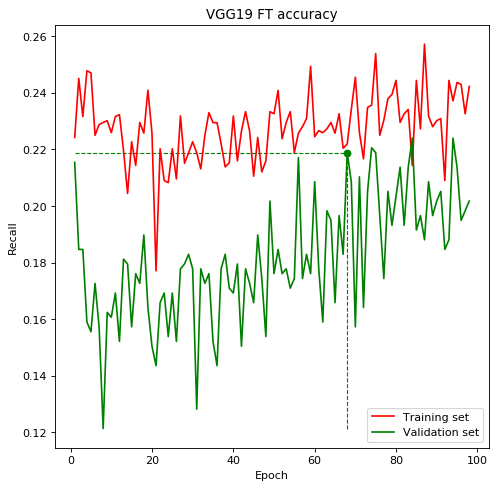

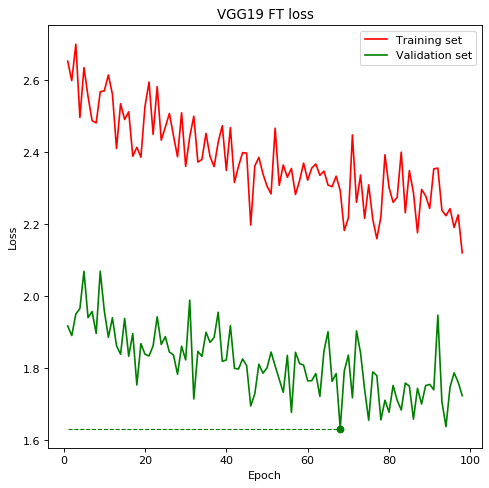

In [17]:
# Model accuracy
plt.figure(figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.title('VGG19 FT accuracy')
plt.ylabel('Recall')
plt.xlabel('Epoch')
plt.plot(epochs_fe, tra_acc_fe, 'r', label='Training set')
plt.plot(epochs_fe, val_acc_fe, 'g', label='Validation set')
plt.plot(opt_epoch_fe, val_acc_fe[opt_epoch_fe-1], 'go')
plt.vlines(opt_epoch_fe, min(val_acc_fe), opt_val_acc_fe, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_acc_fe, 1, opt_epoch_fe, linestyle="dashed", color='g', linewidth=1)
plt.legend(loc='lower right')

# Model loss
plt.figure(figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.title('VGG19 FT loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.plot(epochs_fe, tra_loss_fe, 'r', label='Training set')
plt.plot(epochs_fe, val_loss_fe, 'g', label='Validation set')
plt.plot(opt_epoch_fe, val_loss_fe[opt_epoch_fe-1], 'go')
plt.vlines(opt_epoch_fe, min(val_loss_fe), opt_val_loss_fe, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_loss_fe, 1, opt_epoch_fe, linestyle="dashed", color='g', linewidth=1)
plt.legend();

### Adagrad

In [18]:
vgg19_calc_or_mass_best_Adagrad = create_vgg19(dropout=0.5, fc_size=128, output = 4)

earlystopping = EarlyStopping(monitor='val_loss', mode='min', patience=30, verbose=1)

checkpoint = ModelCheckpoint('../model/vgg19_calc_or_mass_best_Adagrad.h5', 
        monitor='val_loss', mode='min', verbose=1, 
        save_best_only=True, save_freq='epoch'
)

vgg19_calc_or_mass_best_Adagrad.compile(optimizer=optimizers.Adagrad(learning_rate=0.0001),
                                            loss='categorical_crossentropy',
                                            metrics=[tf.keras.metrics.Recall(name='recall')])

In [19]:
# Train
history_vgg19_calc_or_mass_best_Adagrad = vgg19_calc_or_mass_best_Adagrad.fit_generator(
        train_generator,
        steps_per_epoch=n_train_img // 256,
        epochs=300,
        validation_data=validation_generator,
        callbacks=[checkpoint, earlystopping],
        shuffle=True,
        verbose=1,
        initial_epoch=0
)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 11 steps, validate for 5 steps
Epoch 1/300
10/11 [==========================>...] - ETA: 1s - loss: 2.5532 - recall: 0.2121
Epoch 00001: val_loss improved from inf to 1.77054, saving model to ../model/vgg19_calc_or_mass_best_Adagrad.h5
11/11 [==============================] - 21s 2s/step - loss: 2.5255 - recall: 0.2135 - val_loss: 1.7705 - val_recall: 0.2650
Epoch 2/300
10/11 [==========================>...] - ETA: 1s - loss: 2.2988 - recall: 0.2344
Epoch 00002: val_loss improved from 1.77054 to 1.66257, saving model to ../model/vgg19_calc_or_mass_best_Adagrad.h5
11/11 [==============================] - 21s 2s/step - loss: 2.2248 - recall: 0.2340 - val_loss: 1.6626 - val_recall: 0.3026
Epoch 3/300
10/11 [==========================>...] - ETA: 1s - loss: 2.1570 - recall: 0.2391
Epoch 00003: val_loss improved from 1.66257 to 1.61363, saving model to ../model/vgg19_calc_or_mass_best_Adagrad.h5
11/11 [=============================

Epoch 28/300
10/11 [==========================>...] - ETA: 1s - loss: 1.4588 - recall: 0.3242
Epoch 00028: val_loss did not improve from 1.24503
11/11 [==============================] - 22s 2s/step - loss: 1.5001 - recall: 0.3196 - val_loss: 1.2781 - val_recall: 0.2838
Epoch 29/300
10/11 [==========================>...] - ETA: 1s - loss: 1.5368 - recall: 0.3023
Epoch 00029: val_loss did not improve from 1.24503
11/11 [==============================] - 21s 2s/step - loss: 1.5489 - recall: 0.3033 - val_loss: 1.2543 - val_recall: 0.3026
Epoch 30/300
10/11 [==========================>...] - ETA: 1s - loss: 1.4462 - recall: 0.2980
Epoch 00030: val_loss did not improve from 1.24503
11/11 [==============================] - 20s 2s/step - loss: 1.4524 - recall: 0.2979 - val_loss: 1.2771 - val_recall: 0.2786
Epoch 31/300
10/11 [==========================>...] - ETA: 1s - loss: 1.4831 - recall: 0.3106
Epoch 00031: val_loss did not improve from 1.24503
11/11 [==============================] - 21s 

Epoch 57/300
10/11 [==========================>...] - ETA: 1s - loss: 1.3441 - recall: 0.3133
Epoch 00057: val_loss did not improve from 1.14091
11/11 [==============================] - 21s 2s/step - loss: 1.3373 - recall: 0.3189 - val_loss: 1.1933 - val_recall: 0.2735
Epoch 58/300
10/11 [==========================>...] - ETA: 1s - loss: 1.4348 - recall: 0.2977
Epoch 00058: val_loss did not improve from 1.14091
11/11 [==============================] - 21s 2s/step - loss: 1.4590 - recall: 0.2969 - val_loss: 1.2243 - val_recall: 0.2838
Epoch 59/300
10/11 [==========================>...] - ETA: 1s - loss: 1.3541 - recall: 0.3148
Epoch 00059: val_loss did not improve from 1.14091
11/11 [==============================] - 21s 2s/step - loss: 1.3541 - recall: 0.3100 - val_loss: 1.1647 - val_recall: 0.2479
Epoch 60/300
10/11 [==========================>...] - ETA: 1s - loss: 1.4203 - recall: 0.3039
Epoch 00060: val_loss did not improve from 1.14091
11/11 [==============================] - 22s 

In [20]:
models.save_model(vgg19_calc_or_mass_best_Adagrad, '../model/vgg19_calc_or_mass_end_Adagrad.h5')

In [21]:
tra_loss_fe = history_vgg19_calc_or_mass_best_Adagrad.history['loss']
tra_acc_fe = history_vgg19_calc_or_mass_best_Adagrad.history['recall']
val_loss_fe = history_vgg19_calc_or_mass_best_Adagrad.history['val_loss']
val_acc_fe = history_vgg19_calc_or_mass_best_Adagrad.history['val_recall']

epochs_fe = range(1, len(tra_acc_fe)+1)
end_epoch_fe = len(tra_acc_fe)

opt_epoch_fe = val_loss_fe.index(min(val_loss_fe)) + 1

end_val_loss_fe = val_loss_fe[-1]
end_val_acc_fe = val_acc_fe[-1]
opt_val_loss_fe = val_loss_fe[opt_epoch_fe-1]
opt_val_acc_fe = val_acc_fe[opt_epoch_fe-1]

opt_vgg19_calc_or_mass = models.load_model('../model/vgg19_calc_or_mass_best_Adagrad.h5')
test_loss_fe, test_acc_fe = vgg19_calc_or_mass_best_Adagrad.evaluate(test_images, test_labels, verbose=False)
opt_test_loss_fe, opt_test_acc_fe = opt_vgg19_calc_or_mass.evaluate(test_images, test_labels, verbose=False)

print("VGG19 calc or mass\n")

print("Epoch [end]: %d" % end_epoch_fe)
print("Epoch [opt]: %d" % opt_epoch_fe)
print("Valid recall [end]: %.4f" % end_val_acc_fe)
print("Valid recall [opt]: %.4f" % opt_val_acc_fe)
print("Test recall [end]:  %.4f" % test_acc_fe)
print("Test recall [opt]:  %.4f" % opt_test_acc_fe)
print("Valid loss [end]: %.4f" % end_val_loss_fe)
print("Valid loss [opt]: %.4f" % opt_val_loss_fe)
print("Test loss [end]:  %.4f" % test_loss_fe)
print("Test loss [opt]:  %.4f" % opt_test_loss_fe)

VGG19 calc or mass

Epoch [end]: 93
Epoch [opt]: 63
Valid recall [end]: 0.2615
Valid recall [opt]: 0.2667
Test recall [end]:  0.3748
Test recall [opt]:  0.3717
Valid loss [end]: 1.1355
Valid loss [opt]: 1.1293
Test loss [end]:  1.2029
Test loss [opt]:  1.2551


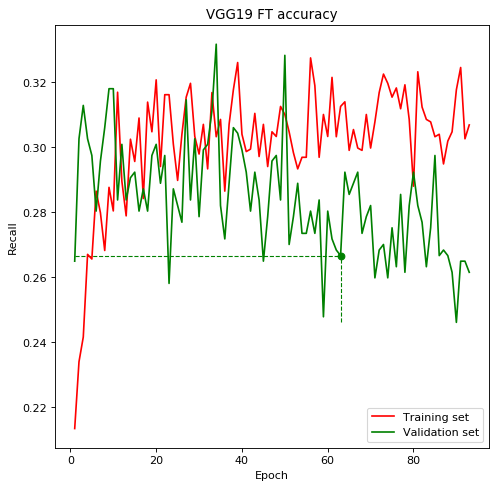

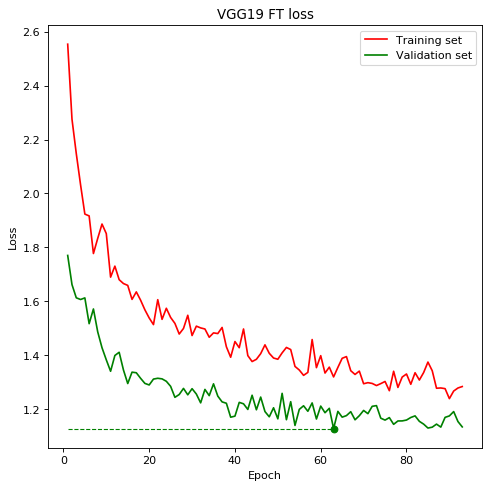

In [22]:
# Model accuracy
plt.figure(figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.title('VGG19 FT accuracy')
plt.ylabel('Recall')
plt.xlabel('Epoch')
plt.plot(epochs_fe, tra_acc_fe, 'r', label='Training set')
plt.plot(epochs_fe, val_acc_fe, 'g', label='Validation set')
plt.plot(opt_epoch_fe, val_acc_fe[opt_epoch_fe-1], 'go')
plt.vlines(opt_epoch_fe, min(val_acc_fe), opt_val_acc_fe, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_acc_fe, 1, opt_epoch_fe, linestyle="dashed", color='g', linewidth=1)
plt.legend(loc='lower right')

# Model loss
plt.figure(figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.title('VGG19 FT loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.plot(epochs_fe, tra_loss_fe, 'r', label='Training set')
plt.plot(epochs_fe, val_loss_fe, 'g', label='Validation set')
plt.plot(opt_epoch_fe, val_loss_fe[opt_epoch_fe-1], 'go')
plt.vlines(opt_epoch_fe, min(val_loss_fe), opt_val_loss_fe, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_loss_fe, 1, opt_epoch_fe, linestyle="dashed", color='g', linewidth=1)
plt.legend();

### Adamax

In [13]:
vgg19_calc_or_mass_best_Adamax = create_vgg19(dropout=0.5, fc_size=128, output = 4)

earlystopping = EarlyStopping(monitor='val_loss', mode='min', patience=30, verbose=1)

checkpoint = ModelCheckpoint('../model/vgg19_calc_or_mass_best_Adamax.h5', 
        monitor='val_loss', mode='min', verbose=1, 
        save_best_only=True, save_freq='epoch'
)

vgg19_calc_or_mass_best_Adamax.compile(optimizer=optimizers.Adamax(learning_rate=0.0001),
                                            loss='categorical_crossentropy',
                                            metrics=[tf.keras.metrics.Recall(name='recall')])

In [14]:
# Train
history_vgg19_calc_or_mass_best_Adamax = vgg19_calc_or_mass_best_Adamax.fit_generator(
        train_generator,
        steps_per_epoch=n_train_img // 256,
        epochs=300,
        validation_data=validation_generator,
        callbacks=[checkpoint, earlystopping],
        shuffle=True,
        verbose=1,
        initial_epoch=0
)

Instructions for updating:
Please use Model.fit, which supports generators.
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 11 steps, validate for 5 steps
Epoch 1/300
10/11 [==========================>...] - ETA: 1s - loss: 2.8326 - recall: 0.2904
Epoch 00001: val_loss improved from inf to 1.63796, saving model to ../model/vgg19_calc_or_mass_best_Adamax.h5
11/11 [==============================] - 26s 2s/step - loss: 2.7692 - recall: 0.2933 - val_loss: 1.6380 - val_recall: 0.3402
Epoch 2/300
10/11 [==========================>...] - ETA: 1s - loss: 1.7616 - recall: 0.3250
Epoch 00002: val_loss improved from 1.63796 to 1.40042, saving model to ../model/vgg19_calc_or_mass_best_Adamax.h5
11/11 [==============================] - 22s 2s/step - loss: 1.7479 - recall: 0.3224 - val_loss: 1.4004 - val_recall: 0.3316
Epoch 3/300
10/11 [==========================>...] - ETA: 1s - loss: 1.6982 - recall: 0.2859
Epoch 00003: val_loss improved from 1.40042 to 1.28737, saving model to ../mod

Epoch 27/300
10/11 [==========================>...] - ETA: 1s - loss: 1.1069 - recall: 0.3375
Epoch 00027: val_loss improved from 1.02861 to 1.02514, saving model to ../model/vgg19_calc_or_mass_best_Adamax.h5
11/11 [==============================] - 22s 2s/step - loss: 1.0965 - recall: 0.3427 - val_loss: 1.0251 - val_recall: 0.2769
Epoch 28/300
10/11 [==========================>...] - ETA: 1s - loss: 1.0869 - recall: 0.3445
Epoch 00028: val_loss did not improve from 1.02514
11/11 [==============================] - 22s 2s/step - loss: 1.0907 - recall: 0.3480 - val_loss: 1.0551 - val_recall: 0.2838
Epoch 29/300
10/11 [==========================>...] - ETA: 1s - loss: 1.1330 - recall: 0.3352
Epoch 00029: val_loss improved from 1.02514 to 1.01758, saving model to ../model/vgg19_calc_or_mass_best_Adamax.h5
11/11 [==============================] - 21s 2s/step - loss: 1.1403 - recall: 0.3351 - val_loss: 1.0176 - val_recall: 0.2786
Epoch 30/300
10/11 [==========================>...] - ETA: 1s 

Epoch 55/300
10/11 [==========================>...] - ETA: 1s - loss: 1.0085 - recall: 0.3746
Epoch 00055: val_loss did not improve from 0.95083
11/11 [==============================] - 21s 2s/step - loss: 1.0064 - recall: 0.3761 - val_loss: 0.9768 - val_recall: 0.3368
Epoch 56/300
10/11 [==========================>...] - ETA: 1s - loss: 1.0109 - recall: 0.3906
Epoch 00056: val_loss did not improve from 0.95083
11/11 [==============================] - 21s 2s/step - loss: 1.0193 - recall: 0.3921 - val_loss: 0.9659 - val_recall: 0.3778
Epoch 57/300
10/11 [==========================>...] - ETA: 1s - loss: 1.0363 - recall: 0.3897
Epoch 00057: val_loss improved from 0.95083 to 0.94031, saving model to ../model/vgg19_calc_or_mass_best_Adamax.h5
11/11 [==============================] - 22s 2s/step - loss: 1.0402 - recall: 0.3883 - val_loss: 0.9403 - val_recall: 0.3470
Epoch 58/300
10/11 [==========================>...] - ETA: 1s - loss: 1.0349 - recall: 0.3695
Epoch 00058: val_loss did not im

Epoch 85/300
10/11 [==========================>...] - ETA: 1s - loss: 0.9878 - recall: 0.3938
Epoch 00085: val_loss did not improve from 0.91093
11/11 [==============================] - 21s 2s/step - loss: 0.9883 - recall: 0.3949 - val_loss: 0.9588 - val_recall: 0.3863
Epoch 86/300
10/11 [==========================>...] - ETA: 1s - loss: 0.9608 - recall: 0.4211
Epoch 00086: val_loss did not improve from 0.91093
11/11 [==============================] - 21s 2s/step - loss: 0.9667 - recall: 0.4190 - val_loss: 0.9240 - val_recall: 0.3846
Epoch 87/300
10/11 [==========================>...] - ETA: 1s - loss: 0.9567 - recall: 0.4226
Epoch 00087: val_loss did not improve from 0.91093
11/11 [==============================] - 20s 2s/step - loss: 0.9693 - recall: 0.4149 - val_loss: 0.9368 - val_recall: 0.3778
Epoch 88/300
10/11 [==========================>...] - ETA: 1s - loss: 0.9395 - recall: 0.4289
Epoch 00088: val_loss did not improve from 0.91093
11/11 [==============================] - 22s 

Epoch 144/300
10/11 [==========================>...] - ETA: 1s - loss: 0.9109 - recall: 0.4655
Epoch 00144: val_loss did not improve from 0.84447
11/11 [==============================] - 21s 2s/step - loss: 0.9139 - recall: 0.4673 - val_loss: 0.9164 - val_recall: 0.4137
Epoch 145/300
10/11 [==========================>...] - ETA: 1s - loss: 0.8854 - recall: 0.4436
Epoch 00145: val_loss did not improve from 0.84447
11/11 [==============================] - 21s 2s/step - loss: 0.8851 - recall: 0.4514 - val_loss: 0.9009 - val_recall: 0.4325
Epoch 146/300
10/11 [==========================>...] - ETA: 1s - loss: 0.9417 - recall: 0.4422
Epoch 00146: val_loss did not improve from 0.84447
11/11 [==============================] - 22s 2s/step - loss: 0.9346 - recall: 0.4517 - val_loss: 0.9024 - val_recall: 0.4239
Epoch 147/300
10/11 [==========================>...] - ETA: 1s - loss: 0.9019 - recall: 0.4945
Epoch 00147: val_loss did not improve from 0.84447
11/11 [==============================] - 

In [15]:
models.save_model(vgg19_calc_or_mass_best_Adamax, '../model/vgg19_calc_or_mass_end_Adamax.h5')

In [16]:
tra_loss_fe = history_vgg19_calc_or_mass_best_Adamax.history['loss']
tra_acc_fe = history_vgg19_calc_or_mass_best_Adamax.history['recall']
val_loss_fe = history_vgg19_calc_or_mass_best_Adamax.history['val_loss']
val_acc_fe = history_vgg19_calc_or_mass_best_Adamax.history['val_recall']

epochs_fe = range(1, len(tra_acc_fe)+1)
end_epoch_fe = len(tra_acc_fe)

opt_epoch_fe = val_loss_fe.index(min(val_loss_fe)) + 1

end_val_loss_fe = val_loss_fe[-1]
end_val_acc_fe = val_acc_fe[-1]
opt_val_loss_fe = val_loss_fe[opt_epoch_fe-1]
opt_val_acc_fe = val_acc_fe[opt_epoch_fe-1]

opt_vgg19_calc_or_mass = models.load_model('../model/vgg19_calc_or_mass_best_Adamax.h5')
test_loss_fe, test_acc_fe = vgg19_calc_or_mass_best_Adamax.evaluate(test_images, test_labels, verbose=False)
opt_test_loss_fe, opt_test_acc_fe = opt_vgg19_calc_or_mass.evaluate(test_images, test_labels, verbose=False)

print("VGG19 calc or mass\n")

print("Epoch [end]: %d" % end_epoch_fe)
print("Epoch [opt]: %d" % opt_epoch_fe)
print("Valid recall [end]: %.4f" % end_val_acc_fe)
print("Valid recall [opt]: %.4f" % opt_val_acc_fe)
print("Test recall [end]:  %.4f" % test_acc_fe)
print("Test recall [opt]:  %.4f" % opt_test_acc_fe)
print("Valid loss [end]: %.4f" % end_val_loss_fe)
print("Valid loss [opt]: %.4f" % opt_val_loss_fe)
print("Test loss [end]:  %.4f" % test_loss_fe)
print("Test loss [opt]:  %.4f" % opt_test_loss_fe)

VGG19 calc or mass

Epoch [end]: 162
Epoch [opt]: 132
Valid recall [end]: 0.4256
Valid recall [opt]: 0.4598
Test recall [end]:  0.4837
Test recall [opt]:  0.5054
Valid loss [end]: 0.8958
Valid loss [opt]: 0.8445
Test loss [end]:  0.8956
Test loss [opt]:  0.8875


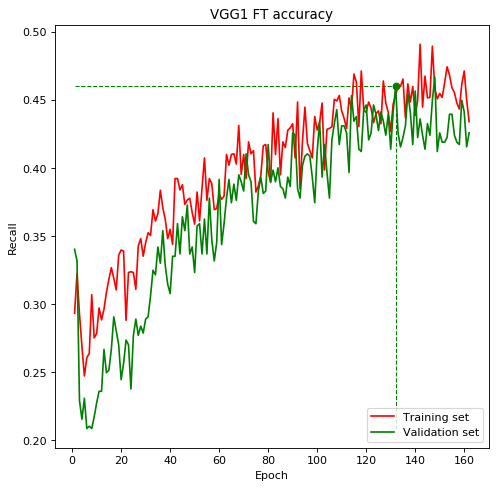

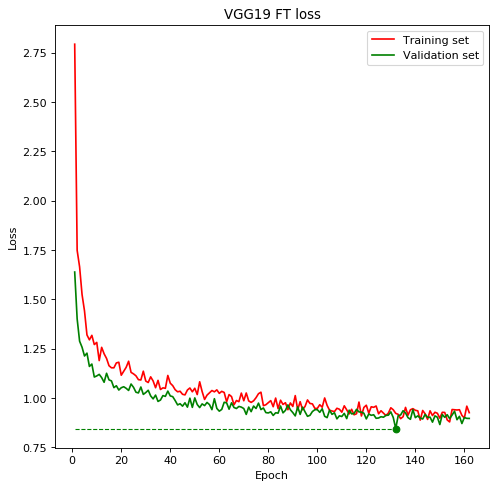

In [17]:
# Model accuracy
plt.figure(figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.title('VGG1 FT accuracy')
plt.ylabel('Recall')
plt.xlabel('Epoch')
plt.plot(epochs_fe, tra_acc_fe, 'r', label='Training set')
plt.plot(epochs_fe, val_acc_fe, 'g', label='Validation set')
plt.plot(opt_epoch_fe, val_acc_fe[opt_epoch_fe-1], 'go')
plt.vlines(opt_epoch_fe, min(val_acc_fe), opt_val_acc_fe, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_acc_fe, 1, opt_epoch_fe, linestyle="dashed", color='g', linewidth=1)
plt.legend(loc='lower right')

# Model loss
plt.figure(figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.title('VGG19 FT loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.plot(epochs_fe, tra_loss_fe, 'r', label='Training set')
plt.plot(epochs_fe, val_loss_fe, 'g', label='Validation set')
plt.plot(opt_epoch_fe, val_loss_fe[opt_epoch_fe-1], 'go')
plt.vlines(opt_epoch_fe, min(val_loss_fe), opt_val_loss_fe, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_loss_fe, 1, opt_epoch_fe, linestyle="dashed", color='g', linewidth=1)
plt.legend();

## Nadam

In [12]:
vgg19_calc_or_mass_best_Nadam = create_vgg19(dropout=0.5, fc_size=128, output = 4)

earlystopping = EarlyStopping(monitor='val_loss', mode='min', patience=30, verbose=1)

checkpoint = ModelCheckpoint('../model/vgg19_calc_or_mass_best_Nadam.h5', 
        monitor='val_loss', mode='min', verbose=1, 
        save_best_only=True, save_freq='epoch'
)

vgg19_calc_or_mass_best_Nadam.compile(optimizer=optimizers.Nadam(learning_rate=0.0001),
                                            loss='categorical_crossentropy',
                                            metrics=[tf.keras.metrics.Recall(name='recall')])

In [13]:
# Train
history_vgg19_calc_or_mass_best_Nadam = vgg19_calc_or_mass_best_Nadam.fit_generator(
        train_generator,
        steps_per_epoch=n_train_img // 256,
        epochs=300,
        validation_data=validation_generator,
        callbacks=[checkpoint, earlystopping],
        shuffle=True,
        verbose=1,
        initial_epoch=0
)

Instructions for updating:
Please use Model.fit, which supports generators.
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 11 steps, validate for 5 steps
Epoch 1/300
10/11 [==========================>...] - ETA: 1s - loss: 2.3878 - recall: 0.2906
Epoch 00001: val_loss improved from inf to 1.39432, saving model to ../model/vgg19_calc_or_mass_best_Nadam.h5
11/11 [==============================] - 25s 2s/step - loss: 2.3036 - recall: 0.2962 - val_loss: 1.3943 - val_recall: 0.3590
Epoch 2/300
10/11 [==========================>...] - ETA: 1s - loss: 1.5535 - recall: 0.3603
Epoch 00002: val_loss did not improve from 1.39432
11/11 [==============================] - 20s 2s/step - loss: 1.5398 - recall: 0.3625 - val_loss: 1.4221 - val_recall: 0.3026
Epoch 3/300
10/11 [==========================>...] - ETA: 1s - loss: 1.5026 - recall: 0.3555
Epoch 00003: val_loss improved from 1.39432 to 1.20092, saving model to ../model/vgg19_calc_or_mass_best_Nadam.h5
11/11 [======================

11/11 [==============================] - 23s 2s/step - loss: 0.9950 - recall: 0.4268 - val_loss: 0.9282 - val_recall: 0.4154
Epoch 27/300
10/11 [==========================>...] - ETA: 1s - loss: 0.9777 - recall: 0.4360
Epoch 00027: val_loss improved from 0.92820 to 0.92636, saving model to ../model/vgg19_calc_or_mass_best_Nadam.h5
11/11 [==============================] - 22s 2s/step - loss: 0.9886 - recall: 0.4255 - val_loss: 0.9264 - val_recall: 0.3932
Epoch 28/300
10/11 [==========================>...] - ETA: 1s - loss: 0.9436 - recall: 0.4394
Epoch 00028: val_loss improved from 0.92636 to 0.91268, saving model to ../model/vgg19_calc_or_mass_best_Nadam.h5
11/11 [==============================] - 22s 2s/step - loss: 0.9523 - recall: 0.4316 - val_loss: 0.9127 - val_recall: 0.3983
Epoch 29/300
10/11 [==========================>...] - ETA: 1s - loss: 0.9831 - recall: 0.4133
Epoch 00029: val_loss did not improve from 0.91268
11/11 [==============================] - 22s 2s/step - loss: 0.9

Epoch 56/300
10/11 [==========================>...] - ETA: 1s - loss: 0.8948 - recall: 0.4604
Epoch 00056: val_loss did not improve from 0.89533
11/11 [==============================] - 21s 2s/step - loss: 0.8983 - recall: 0.4620 - val_loss: 0.9500 - val_recall: 0.4274
Epoch 57/300
10/11 [==========================>...] - ETA: 1s - loss: 0.9163 - recall: 0.4705
Epoch 00057: val_loss did not improve from 0.89533
11/11 [==============================] - 21s 2s/step - loss: 0.9224 - recall: 0.4666 - val_loss: 0.9613 - val_recall: 0.4427
Epoch 58/300
10/11 [==========================>...] - ETA: 1s - loss: 0.9284 - recall: 0.4617
Epoch 00058: val_loss did not improve from 0.89533
11/11 [==============================] - 22s 2s/step - loss: 0.9324 - recall: 0.4567 - val_loss: 0.9447 - val_recall: 0.4256
Epoch 59/300
10/11 [==========================>...] - ETA: 1s - loss: 0.9138 - recall: 0.4495
Epoch 00059: val_loss did not improve from 0.89533
11/11 [==============================] - 20s 

Epoch 86/300
10/11 [==========================>...] - ETA: 1s - loss: 0.8776 - recall: 0.4781
Epoch 00086: val_loss did not improve from 0.87531
11/11 [==============================] - 22s 2s/step - loss: 0.8744 - recall: 0.4822 - val_loss: 0.9371 - val_recall: 0.4359
Epoch 87/300
10/11 [==========================>...] - ETA: 1s - loss: 0.8886 - recall: 0.4714
Epoch 00087: val_loss did not improve from 0.87531
11/11 [==============================] - 20s 2s/step - loss: 0.8892 - recall: 0.4711 - val_loss: 0.9404 - val_recall: 0.4718
Epoch 88/300
10/11 [==========================>...] - ETA: 1s - loss: 0.8734 - recall: 0.5008
Epoch 00088: val_loss did not improve from 0.87531
11/11 [==============================] - 22s 2s/step - loss: 0.8707 - recall: 0.5007 - val_loss: 0.8879 - val_recall: 0.4513
Epoch 89/300
10/11 [==========================>...] - ETA: 1s - loss: 0.8963 - recall: 0.4604
Epoch 00089: val_loss did not improve from 0.87531
11/11 [==============================] - 21s 

In [14]:
models.save_model(vgg19_calc_or_mass_best_Nadam, '../model/vgg19_calc_or_mass_end_Nadam.h5')

In [15]:
tra_loss_fe = history_vgg19_calc_or_mass_best_Nadam.history['loss']
tra_acc_fe = history_vgg19_calc_or_mass_best_Nadam.history['recall']
val_loss_fe = history_vgg19_calc_or_mass_best_Nadam.history['val_loss']
val_acc_fe = history_vgg19_calc_or_mass_best_Nadam.history['val_recall']

epochs_fe = range(1, len(tra_acc_fe)+1)
end_epoch_fe = len(tra_acc_fe)

opt_epoch_fe = val_loss_fe.index(min(val_loss_fe)) + 1

end_val_loss_fe = val_loss_fe[-1]
end_val_acc_fe = val_acc_fe[-1]
opt_val_loss_fe = val_loss_fe[opt_epoch_fe-1]
opt_val_acc_fe = val_acc_fe[opt_epoch_fe-1]

opt_vgg19_calc_or_mass = models.load_model('../model/vgg19_calc_or_mass_best_Nadam.h5')
test_loss_fe, test_acc_fe = vgg19_calc_or_mass_best_Nadam.evaluate(test_images, test_labels, verbose=False)
opt_test_loss_fe, opt_test_acc_fe = opt_vgg19_calc_or_mass.evaluate(test_images, test_labels, verbose=False)

print("VGG19 calc or mass\n")

print("Epoch [end]: %d" % end_epoch_fe)
print("Epoch [opt]: %d" % opt_epoch_fe)
print("Valid recall [end]: %.4f" % end_val_acc_fe)
print("Valid recall [opt]: %.4f" % opt_val_acc_fe)
print("Test recall [end]:  %.4f" % test_acc_fe)
print("Test recall [opt]:  %.4f" % opt_test_acc_fe)
print("Valid loss [end]: %.4f" % end_val_loss_fe)
print("Valid loss [opt]: %.4f" % opt_val_loss_fe)
print("Test loss [end]:  %.4f" % test_loss_fe)
print("Test loss [opt]:  %.4f" % opt_test_loss_fe)

VGG19 calc or mass

Epoch [end]: 102
Epoch [opt]: 72
Valid recall [end]: 0.4444
Valid recall [opt]: 0.4427
Test recall [end]:  0.5319
Test recall [opt]:  0.4930
Valid loss [end]: 0.9261
Valid loss [opt]: 0.8753
Test loss [end]:  0.8975
Test loss [opt]:  0.8520


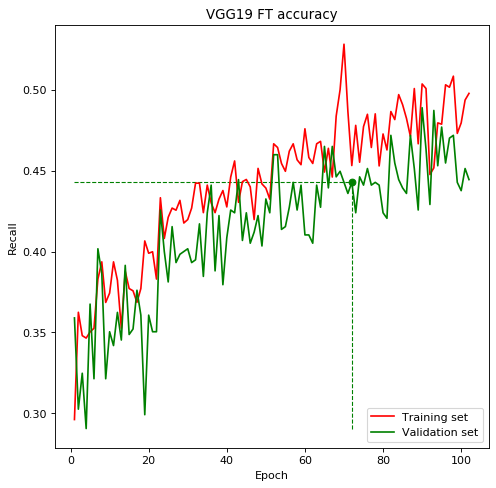

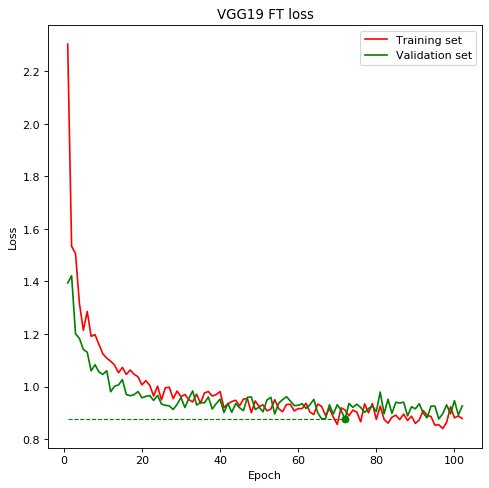

In [16]:
# Model accuracy
plt.figure(figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.title('VGG19 FT accuracy')
plt.ylabel('Recall')
plt.xlabel('Epoch')
plt.plot(epochs_fe, tra_acc_fe, 'r', label='Training set')
plt.plot(epochs_fe, val_acc_fe, 'g', label='Validation set')
plt.plot(opt_epoch_fe, val_acc_fe[opt_epoch_fe-1], 'go')
plt.vlines(opt_epoch_fe, min(val_acc_fe), opt_val_acc_fe, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_acc_fe, 1, opt_epoch_fe, linestyle="dashed", color='g', linewidth=1)
plt.legend(loc='lower right')

# Model loss
plt.figure(figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.title('VGG19 FT loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.plot(epochs_fe, tra_loss_fe, 'r', label='Training set')
plt.plot(epochs_fe, val_loss_fe, 'g', label='Validation set')
plt.plot(opt_epoch_fe, val_loss_fe[opt_epoch_fe-1], 'go')
plt.vlines(opt_epoch_fe, min(val_loss_fe), opt_val_loss_fe, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_loss_fe, 1, opt_epoch_fe, linestyle="dashed", color='g', linewidth=1)
plt.legend();

#### fine tuning

In [17]:
vgg19_calc_or_mass_fine_Adam = models.load_model('../model/vgg19_calc_or_mass_best_Adam.h5')

for layer in vgg19_calc_or_mass_fine_Adam.layers:
    if layer.name.startswith('block5_conv4'):
        layer.trainable = True
    else:
        layer.trainable = False

# Recompile the model ()
vgg19_calc_or_mass_fine_Adam.compile(optimizer=optimizers.Adam(learning_rate=0.0001),
                                            loss='categorical_crossentropy',
                                            metrics=[tf.keras.metrics.Recall(name='recall')])

vgg19_calc_or_mass_fine_Adam.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 256, 256, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 256, 256, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 128, 128, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 128, 128, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 128, 128, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 64, 64, 128)       0     

In [18]:
early_stop = EarlyStopping(monitor='val_loss', mode='min', patience=30, verbose=1)

checkpoint = ModelCheckpoint(
        '../model/vgg19_calc_or_mass_fine_Adam_best.h5',
        monitor='val_loss',
        mode='min',
        verbose=1, 
     
    save_best_only=True, 
        save_freq='epoch')

In [19]:
history_fit = vgg19_calc_or_mass_fine_Adam.fit_generator(
        train_generator,
        steps_per_epoch=n_train_img // 256,
        epochs=300,
        validation_data=validation_generator,
        callbacks=[early_stop, checkpoint],
        shuffle=True,
        verbose=1,
        initial_epoch=0)

Instructions for updating:
Please use Model.fit, which supports generators.
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 10 steps, validate for 5 steps
Epoch 1/300
 1/10 [==>...........................] - ETA: 28sWARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: 


UnknownError: 2 root error(s) found.
  (0) Unknown:  Failed to get convolution algorithm. This is probably because cuDNN failed to initialize, so try looking to see if a warning log message was printed above.
	 [[node model/block1_conv1/Conv2D (defined at <ipython-input-19-0be85613e517>:9) ]]
	 [[metrics/recall/assert_less_equal/Assert/AssertGuard/pivot_f/_13/_37]]
  (1) Unknown:  Failed to get convolution algorithm. This is probably because cuDNN failed to initialize, so try looking to see if a warning log message was printed above.
	 [[node model/block1_conv1/Conv2D (defined at <ipython-input-19-0be85613e517>:9) ]]
0 successful operations.
0 derived errors ignored. [Op:__inference_distributed_function_4357]

Function call stack:
distributed_function -> distributed_function


In [22]:
models.save_model(vgg19_calc_or_mass_fine_Adam, '../model/vgg19_calc_or_mass_fine_Adam_end.h5')

In [25]:
# History of accuracy and loss
tra_loss_fe = history_fit.history['loss']
tra_acc_fe = history_fit.history['recall']
val_loss_fe = history_fit.history['val_loss']
val_acc_fe = history_fit.history['val_recall']

# Total number of epochs training
epochs_fe = range(1, len(tra_acc_fe)+1)
end_epoch_fe = len(tra_acc_fe)

# Epoch when reached the validation loss minimum
opt_epoch_fe = val_loss_fe.index(min(val_loss_fe)) + 1

# Loss and accuracy on the validation set
end_val_loss_fe = val_loss_fe[-1]
end_val_acc_fe = val_acc_fe[-1]
opt_val_loss_fe = val_loss_fe[opt_epoch_fe-1]
opt_val_acc_fe = val_acc_fe[opt_epoch_fe-1]

# Loss and accuracy on the test set
opt_vgg19_calc_or_mass_fine_Adam = models.load_model('../model/vgg19_calc_or_mass_fine_Adam_best.h5')
test_loss_fe, test_acc_fe = vgg19_calc_or_mass_fine_Adam.evaluate(test_images, test_labels, verbose=False)
opt_test_loss_fe, opt_test_acc_fe = opt_vgg19_calc_or_mass_fine_Adam.evaluate(test_images, test_labels, verbose=False)

print("VGG1recall Fine Tuning\n")

print("Epoch [end]: %d" % end_epoch_fe)
print("Epoch [opt]: %d" % opt_epoch_fe)
print("Valid recall [end]: %.4f" % end_val_acc_fe)
print("Valid recall [opt]: %.4f" % opt_val_acc_fe)
print("Test recall [end]:  %.4f" % test_acc_fe)
print("Test recall [opt]:  %.4f" % opt_test_acc_fe)
print("Valid loss [end]: %.4f" % end_val_loss_fe)
print("Valid loss [opt]: %.4f" % opt_val_loss_fe)
print("Test loss [end]:  %.4f" % test_loss_fe)
print("Test loss [opt]:  %.4f" % opt_test_loss_fe)

VGG1recall Fine Tuning

Epoch [end]: 105
Epoch [opt]: 75
Valid recall [end]: 0.8991
Valid recall [opt]: 0.9077
Test recall [end]:  0.9020
Test recall [opt]:  0.8942
Valid loss [end]: 0.2442
Valid loss [opt]: 0.2074
Test loss [end]:  0.2484
Test loss [opt]:  0.2736


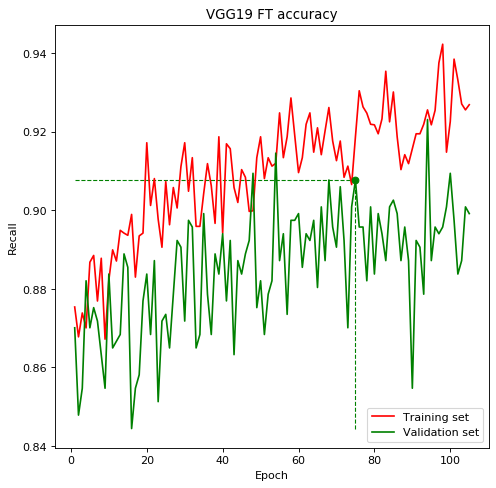

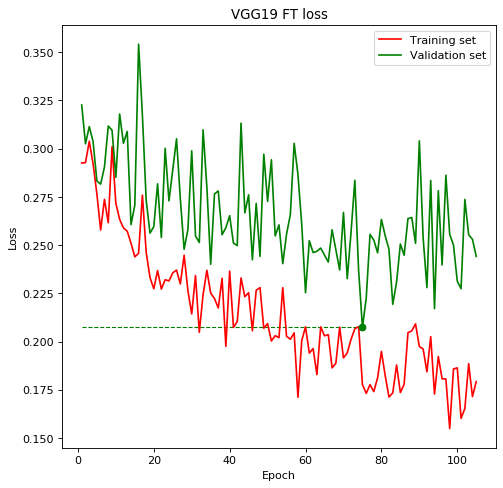

In [26]:
# Model accuracy
plt.figure(figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.title('VGG19 FT accuracy')
plt.ylabel('Recall')
plt.xlabel('Epoch')
plt.plot(epochs_fe, tra_acc_fe, 'r', label='Training set')
plt.plot(epochs_fe, val_acc_fe, 'g', label='Validation set')
plt.plot(opt_epoch_fe, val_acc_fe[opt_epoch_fe-1], 'go')
plt.vlines(opt_epoch_fe, min(val_acc_fe), opt_val_acc_fe, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_acc_fe, 1, opt_epoch_fe, linestyle="dashed", color='g', linewidth=1)
plt.legend(loc='lower right')

# Model loss
plt.figure(figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.title('VGG19 FT loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.plot(epochs_fe, tra_loss_fe, 'r', label='Training set')
plt.plot(epochs_fe, val_loss_fe, 'g', label='Validation set')
plt.plot(opt_epoch_fe, val_loss_fe[opt_epoch_fe-1], 'go')
plt.vlines(opt_epoch_fe, min(val_loss_fe), opt_val_loss_fe, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_loss_fe, 1, opt_epoch_fe, linestyle="dashed", color='g', linewidth=1)
plt.legend();

In [27]:
vgg19_calc_or_mass_fine_Adam2 = models.load_model('../model/vgg19_calc_or_mass_fine_Adam_best.h5')

for layer in vgg19_calc_or_mass_fine_Adam2.layers:
    if layer.name in ('block5_conv2', 'block5_conv3'):
        layer.trainable = True
    else:
        layer.trainable = False

# Recompile the model ()
vgg19_calc_or_mass_fine_Adam2.compile(optimizer=optimizers.Adam(learning_rate=0.0001),
                                            loss='categorical_crossentropy',
                                            metrics=[tf.keras.metrics.Recall(name='recall')])

vgg19_calc_or_mass_fine_Adam.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 256, 256, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 256, 256, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 128, 128, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 128, 128, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 128, 128, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 64, 64, 128)       0     

In [28]:
early_stop = EarlyStopping(monitor='val_loss', mode='min', patience=30, verbose=1)

checkpoint = ModelCheckpoint(
        '../model/vgg19_calc_or_mass_fine_Adam_best2.h5',
        monitor='val_loss',
        mode='min',
        verbose=1, 
     
    save_best_only=True, 
        save_freq='epoch')

In [29]:
history_fit = vgg19_calc_or_mass_fine_Adam2.fit_generator(
        train_generator,
        steps_per_epoch=n_train_img // 256,
        epochs=300,
        validation_data=validation_generator,
        callbacks=[early_stop, checkpoint],
        shuffle=True,
        verbose=1,
        initial_epoch=0)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 11 steps, validate for 5 steps
Epoch 1/300
10/11 [==========================>...] - ETA: 1s - loss: 0.2397 - recall: 0.8930
Epoch 00001: val_loss improved from inf to 0.31175, saving model to ../model/vgg19_calc_or_mass_fine_Adam_best2.h5
11/11 [==============================] - 21s 2s/step - loss: 0.2305 - recall: 0.8936 - val_loss: 0.3118 - val_recall: 0.8786
Epoch 2/300
10/11 [==========================>...] - ETA: 1s - loss: 0.2113 - recall: 0.9109
Epoch 00002: val_loss improved from 0.31175 to 0.25478, saving model to ../model/vgg19_calc_or_mass_fine_Adam_best2.h5
11/11 [==============================] - 21s 2s/step - loss: 0.2024 - recall: 0.9119 - val_loss: 0.2548 - val_recall: 0.8838
Epoch 3/300
10/11 [==========================>...] - ETA: 1s - loss: 0.2509 - recall: 0.8965
Epoch 00003: val_loss did not improve from 0.25478
11/11 [==============================] - 21s 2s/step - loss: 0.2479 - recall: 0.8974 - val_loss

10/11 [==========================>...] - ETA: 1s - loss: 0.1560 - recall: 0.9375
Epoch 00059: val_loss did not improve from 0.20283
11/11 [==============================] - 21s 2s/step - loss: 0.1468 - recall: 0.9384 - val_loss: 0.2339 - val_recall: 0.9094
Epoch 60/300
10/11 [==========================>...] - ETA: 1s - loss: 0.1786 - recall: 0.9293
Epoch 00060: val_loss did not improve from 0.20283
11/11 [==============================] - 20s 2s/step - loss: 0.1792 - recall: 0.9301 - val_loss: 0.3492 - val_recall: 0.8821
Epoch 61/300
10/11 [==========================>...] - ETA: 1s - loss: 0.1815 - recall: 0.9219
Epoch 00061: val_loss did not improve from 0.20283
11/11 [==============================] - 22s 2s/step - loss: 0.1872 - recall: 0.9190 - val_loss: 0.2755 - val_recall: 0.8855
Epoch 62/300
10/11 [==========================>...] - ETA: 1s - loss: 0.1730 - recall: 0.9293
Epoch 00062: val_loss did not improve from 0.20283
11/11 [==============================] - 20s 2s/step - los

In [30]:
models.save_model(vgg19_calc_or_mass_fine_Adam2, '../model/vgg19_calc_or_mass_fine_Adam_end2.h5')

In [31]:
# History of accuracy and loss
tra_loss_fe = history_fit.history['loss']
tra_acc_fe = history_fit.history['recall']
val_loss_fe = history_fit.history['val_loss']
val_acc_fe = history_fit.history['val_recall']

# Total number of epochs training
epochs_fe = range(1, len(tra_acc_fe)+1)
end_epoch_fe = len(tra_acc_fe)

# Epoch when reached the validation loss minimum
opt_epoch_fe = val_loss_fe.index(min(val_loss_fe)) + 1

# Loss and accuracy on the validation set
end_val_loss_fe = val_loss_fe[-1]
end_val_acc_fe = val_acc_fe[-1]
opt_val_loss_fe = val_loss_fe[opt_epoch_fe-1]
opt_val_acc_fe = val_acc_fe[opt_epoch_fe-1]

# Loss and accuracy on the test set
opt_vgg19_calc_or_mass_fine_Adam2 = models.load_model('../model/vgg19_calc_or_mass_fine_Adam_best2.h5')
test_loss_fe, test_acc_fe = vgg19_calc_or_mass_fine_Adam2.evaluate(test_images, test_labels, verbose=False)
opt_test_loss_fe, opt_test_acc_fe = opt_vgg19_calc_or_mass_fine_Adam2.evaluate(test_images, test_labels, verbose=False)

print("VGG19 Fine Tuning\n")

print("Epoch [end]: %d" % end_epoch_fe)
print("Epoch [opt]: %d" % opt_epoch_fe)
print("Valid recall [end]: %.4f" % end_val_acc_fe)
print("Valid recall [opt]: %.4f" % opt_val_acc_fe)
print("Test recall [end]:  %.4f" % test_acc_fe)
print("Test recall [opt]:  %.4f" % opt_test_acc_fe)
print("Valid loss [end]: %.4f" % end_val_loss_fe)
print("Valid loss [opt]: %.4f" % opt_val_loss_fe)
print("Test loss [end]:  %.4f" % test_loss_fe)
print("Test loss [opt]:  %.4f" % opt_test_loss_fe)

VGG19 Fine Tuning

Epoch [end]: 85
Epoch [opt]: 55
Valid recall [end]: 0.8974
Valid recall [opt]: 0.9197
Test recall [end]:  0.9082
Test recall [opt]:  0.9269
Valid loss [end]: 0.2653
Valid loss [opt]: 0.2028
Test loss [end]:  0.2369
Test loss [opt]:  0.2120


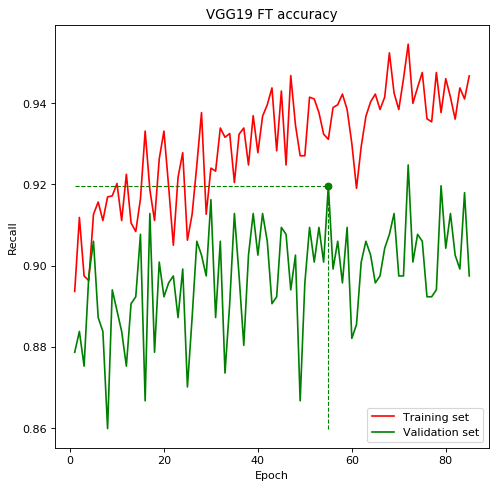

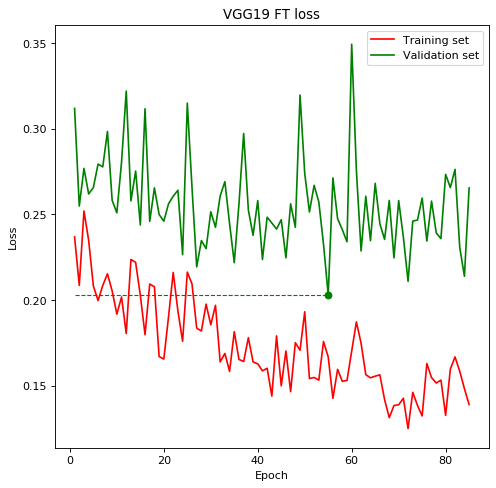

In [32]:
# Model accuracy
plt.figure(figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.title('VGG19 FT accuracy')
plt.ylabel('Recall')
plt.xlabel('Epoch')
plt.plot(epochs_fe, tra_acc_fe, 'r', label='Training set')
plt.plot(epochs_fe, val_acc_fe, 'g', label='Validation set')
plt.plot(opt_epoch_fe, val_acc_fe[opt_epoch_fe-1], 'go')
plt.vlines(opt_epoch_fe, min(val_acc_fe), opt_val_acc_fe, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_acc_fe, 1, opt_epoch_fe, linestyle="dashed", color='g', linewidth=1)
plt.legend(loc='lower right')

# Model loss
plt.figure(figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.title('VGG19 FT loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.plot(epochs_fe, tra_loss_fe, 'r', label='Training set')
plt.plot(epochs_fe, val_loss_fe, 'g', label='Validation set')
plt.plot(opt_epoch_fe, val_loss_fe[opt_epoch_fe-1], 'go')
plt.vlines(opt_epoch_fe, min(val_loss_fe), opt_val_loss_fe, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_loss_fe, 1, opt_epoch_fe, linestyle="dashed", color='g', linewidth=1)
plt.legend();

In [13]:
vgg19_calc_or_mass_fine_Adam3 = models.load_model('../model/vgg19_calc_or_mass_fine_Adam_best2.h5')

for layer in vgg19_calc_or_mass_fine_Adam3.layers:
    if layer.name in ('block5_conv1', 'block5_conv2', 'block5_conv3'):
        layer.trainable = True
    else:
        layer.trainable = False

# Recompile the model ()
vgg19_calc_or_mass_fine_Adam3.compile(optimizer=optimizers.Adam(learning_rate=0.0001),
                                            loss='categorical_crossentropy',
                                            metrics=[tf.keras.metrics.Recall(name='recall')])

vgg19_calc_or_mass_fine_Adam3.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 256, 256, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 256, 256, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 128, 128, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 128, 128, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 128, 128, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 64, 64, 128)       0     

In [14]:
early_stop = EarlyStopping(monitor='val_loss', mode='min', patience=30, verbose=1)

checkpoint = ModelCheckpoint(
        '../model/vgg19_calc_or_mass_fine_Adam_best3.h5',
        monitor='val_loss',
        mode='min',
        verbose=1, 
     
    save_best_only=True, 
        save_freq='epoch')

In [15]:
history_fit = vgg19_calc_or_mass_fine_Adam3.fit_generator(
        train_generator,
        steps_per_epoch=n_train_img // 256,
        epochs=300,
        validation_data=validation_generator,
        callbacks=[early_stop, checkpoint],
        shuffle=True,
        verbose=1,
        initial_epoch=0)

Instructions for updating:
Please use Model.fit, which supports generators.
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 11 steps, validate for 5 steps
Epoch 1/300
10/11 [==========================>...] - ETA: 1s - loss: 0.2837 - recall: 0.8872
Epoch 00001: val_loss improved from inf to 0.30875, saving model to ../model/vgg19_calc_or_mass_fine_Adam_best3.h5
11/11 [==============================] - 24s 2s/step - loss: 0.2798 - recall: 0.8875 - val_loss: 0.3088 - val_recall: 0.8838
Epoch 2/300
10/11 [==========================>...] - ETA: 1s - loss: 0.2020 - recall: 0.9266
Epoch 00002: val_loss improved from 0.30875 to 0.26468, saving model to ../model/vgg19_calc_or_mass_fine_Adam_best3.h5
11/11 [==============================] - 22s 2s/step - loss: 0.2046 - recall: 0.9247 - val_loss: 0.2647 - val_recall: 0.9060
Epoch 3/300
10/11 [==========================>...] - ETA: 1s - loss: 0.1963 - recall: 0.9158
Epoch 00003: val_loss improved from 0.26468 to 0.22849, saving model t

Epoch 29/300
10/11 [==========================>...] - ETA: 1s - loss: 0.1568 - recall: 0.9453
Epoch 00029: val_loss did not improve from 0.20820
11/11 [==============================] - 22s 2s/step - loss: 0.1507 - recall: 0.9474 - val_loss: 0.2646 - val_recall: 0.9077
Epoch 30/300
10/11 [==========================>...] - ETA: 1s - loss: 0.1642 - recall: 0.9281
Epoch 00030: val_loss did not improve from 0.20820
11/11 [==============================] - 22s 2s/step - loss: 0.1629 - recall: 0.9283 - val_loss: 0.2154 - val_recall: 0.9128
Epoch 31/300
10/11 [==========================>...] - ETA: 1s - loss: 0.1347 - recall: 0.9391
Epoch 00031: val_loss did not improve from 0.20820
11/11 [==============================] - 21s 2s/step - loss: 0.1312 - recall: 0.9418 - val_loss: 0.2505 - val_recall: 0.9197
Epoch 32/300
10/11 [==========================>...] - ETA: 1s - loss: 0.1437 - recall: 0.9461
Epoch 00032: val_loss did not improve from 0.20820
11/11 [==============================] - 20s 

In [16]:
models.save_model(vgg19_calc_or_mass_fine_Adam3, '../model/vgg19_calc_or_mass_fine_Adam_end3.h5')

In [17]:
# History of accuracy and loss
tra_loss_fe = history_fit.history['loss']
tra_acc_fe = history_fit.history['recall']
val_loss_fe = history_fit.history['val_loss']
val_acc_fe = history_fit.history['val_recall']

# Total number of epochs training
epochs_fe = range(1, len(tra_acc_fe)+1)
end_epoch_fe = len(tra_acc_fe)

# Epoch when reached the validation loss minimum
opt_epoch_fe = val_loss_fe.index(min(val_loss_fe)) + 1

# Loss and accuracy on the validation set
end_val_loss_fe = val_loss_fe[-1]
end_val_acc_fe = val_acc_fe[-1]
opt_val_loss_fe = val_loss_fe[opt_epoch_fe-1]
opt_val_acc_fe = val_acc_fe[opt_epoch_fe-1]

# Loss and accuracy on the test set
opt_vgg19_calc_or_mass_fine_Adam3 = models.load_model('../model/vgg19_calc_or_mass_fine_Adam_best3.h5')
test_loss_fe, test_acc_fe = vgg19_calc_or_mass_fine_Adam3.evaluate(test_images, test_labels, verbose=False)
opt_test_loss_fe, opt_test_acc_fe = opt_vgg19_calc_or_mass_fine_Adam3.evaluate(test_images, test_labels, verbose=False)

print("VGG19 Fine Tuning\n")

print("Epoch [end]: %d" % end_epoch_fe)
print("Epoch [opt]: %d" % opt_epoch_fe)
print("Valid recall [end]: %.4f" % end_val_acc_fe)
print("Valid recall [opt]: %.4f" % opt_val_acc_fe)
print("Test recall [end]:  %.4f" % test_acc_fe)
print("Test recall [opt]:  %.4f" % opt_test_acc_fe)
print("Valid loss [end]: %.4f" % end_val_loss_fe)
print("Valid loss [opt]: %.4f" % opt_val_loss_fe)
print("Test loss [end]:  %.4f" % test_loss_fe)
print("Test loss [opt]:  %.4f" % opt_test_loss_fe)

VGG19 Fine Tuning

Epoch [end]: 70
Epoch [opt]: 40
Valid recall [end]: 0.9179
Valid recall [opt]: 0.9162
Test recall [end]:  0.9191
Test recall [opt]:  0.9347
Valid loss [end]: 0.2335
Valid loss [opt]: 0.2079
Test loss [end]:  0.2309
Test loss [opt]:  0.1804


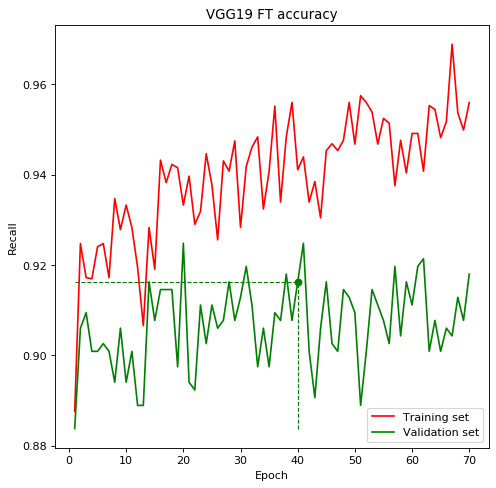

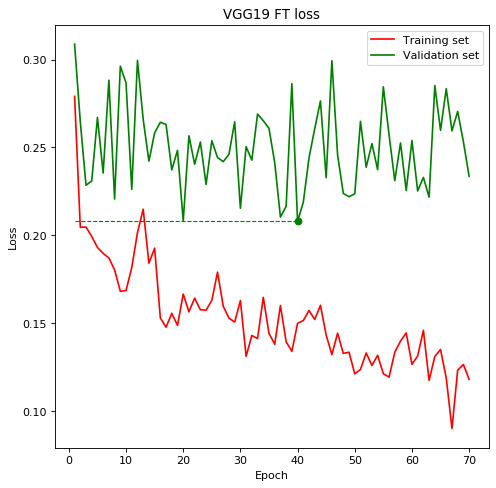

In [18]:
# Model accuracy
plt.figure(figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.title('VGG19 FT accuracy')
plt.ylabel('Recall')
plt.xlabel('Epoch')
plt.plot(epochs_fe, tra_acc_fe, 'r', label='Training set')
plt.plot(epochs_fe, val_acc_fe, 'g', label='Validation set')
plt.plot(opt_epoch_fe, val_acc_fe[opt_epoch_fe-1], 'go')
plt.vlines(opt_epoch_fe, min(val_acc_fe), opt_val_acc_fe, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_acc_fe, 1, opt_epoch_fe, linestyle="dashed", color='g', linewidth=1)
plt.legend(loc='lower right')

# Model loss
plt.figure(figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.title('VGG19 FT loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.plot(epochs_fe, tra_loss_fe, 'r', label='Training set')
plt.plot(epochs_fe, val_loss_fe, 'g', label='Validation set')
plt.plot(opt_epoch_fe, val_loss_fe[opt_epoch_fe-1], 'go')
plt.vlines(opt_epoch_fe, min(val_loss_fe), opt_val_loss_fe, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_loss_fe, 1, opt_epoch_fe, linestyle="dashed", color='g', linewidth=1)
plt.legend();